<a href="https://colab.research.google.com/github/Rebecca-kve/FreeCodeCamp/blob/main/Machine%20Learning%20with%20Python/Copy_of_fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

!apt install wget
!apt install unzip

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2024-10-18 08:34:51--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.3’

cats_and_dogs.zip.3 100%[===================>]  67.43M   292MB/s    in 0.2s    

2024-10-18 08:34:52 (292 MB/s) - ‘cats_and_dogs.zip.3’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Create ImageDataGenerator instances for training, validation, and test datasets
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Create the image generators
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary'
)

test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,  # No labels for test data
    shuffle=False      # Keep the order for predictions
)

# Print the output for verification
print(f'Total training images: {total_train}')
print(f'Total validation images: {total_val}')
print(f'Total test images: {total_test}')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.
Total training images: 2001
Total validation images: 1001
Total test images: 51


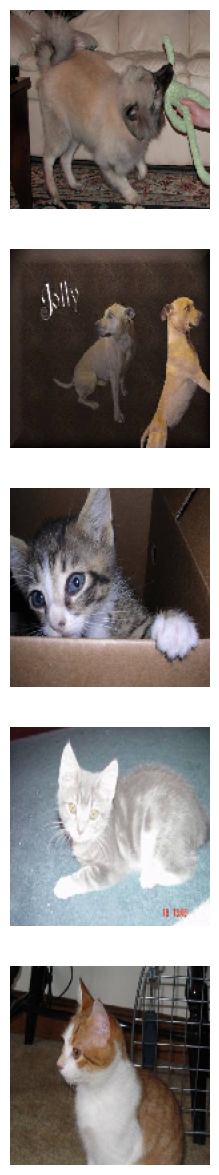

In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
# Create an augmented ImageDataGenerator for the training dataset
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,        # Randomly rotate images in the range (degrees, 0 to 40)
    width_shift_range=0.2,    # Randomly translate images horizontally (20% of total width)
    height_shift_range=0.2,   # Randomly translate images vertically (20% of total height)
    shear_range=0.1,          # Shear transformations
    zoom_range=0.1,           # Randomly zoom into images
    horizontal_flip=True,      # Randomly flip images
    fill_mode='nearest'       # Fill pixels that are newly created when the image is transformed
)

Found 2000 images belonging to 2 classes.


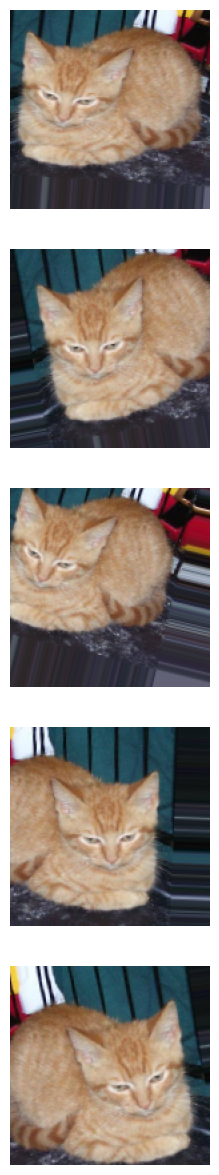

In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [ ]:

# Initialize the model

model = Sequential(
   [ tf.keras.layers.Conv2D(16, 3, activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),  # Increase dropout slightly to reduce overfitting

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'), # Increase Dense layer size
    tf.keras.layers.Dropout(0.3),  # Add dropout to the Dense layer
    tf.keras.layers.Dense(2, activation = 'sigmoid')] # was softmax before

)
"""
model.compile( optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy']
)
"""

# low learning rate version
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()




Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 499,042 (1.90 MB)

 Trainable params: 499,042 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Change learning rates
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                   factor=0.1,
                                                   patience=3,
                                                   verbose=1)


In [ ]:
# Train your model
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[early_stopping]
)


# Your evaluation code goes here


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.4918 - loss: 0.6944 - val_accuracy: 0.5078 - val_loss: 0.6890
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5391 - loss: 0.6878 - val_accuracy: 0.4327 - val_loss: 0.6965
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.5311 - loss: 0.6901 - val_accuracy: 0.4978 - val_loss: 0.6888
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4844 - loss: 0.6925 - val_accuracy: 0.5962 - val_loss: 0.6865
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.5415 - loss: 0.6886 - val_accuracy: 0.5100 - val_loss: 0.6856
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5391 - loss: 0.6830 - val_accuracy: 0.5000 - val_loss: 0.6884
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.5376 - loss: 0.6871 - val_accuracy: 0.5770 - val_loss: 0.6804
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5000 - loss: 0.6941 - val_accuracy: 0.5865 - val_l

In [ ]:
from tensorflow.keras.preprocessing import image
import os
import numpy as np
from PIL import UnidentifiedImageError  # To handle image loading issues

test_images = []

# Supported image file extensions
valid_extensions = ['.jpg', '.jpeg', '.png']

for img_name in os.listdir(test_dir):
    # Ensure the file is an image based on its extension
    if any(img_name.lower().endswith(ext) for ext in valid_extensions):
        img_path = os.path.join(test_dir, img_name)
        try:
            # Load and resize image
            img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img_array = image.img_to_array(img)  # Convert the image to an array
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
            img_array /= 255.0  # Rescale as in training
            test_images.append(img_array)
        except UnidentifiedImageError:
            print(f"Skipping file {img_name} - not a valid image.")

test_images = np.vstack(test_images)  # Stack all images into a single array

# Make predictions on the test data
probabilities = model.predict(test_images)

# If the output is a 2D array, flatten it into a 1D array
probabilities = probabilities.flatten()



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


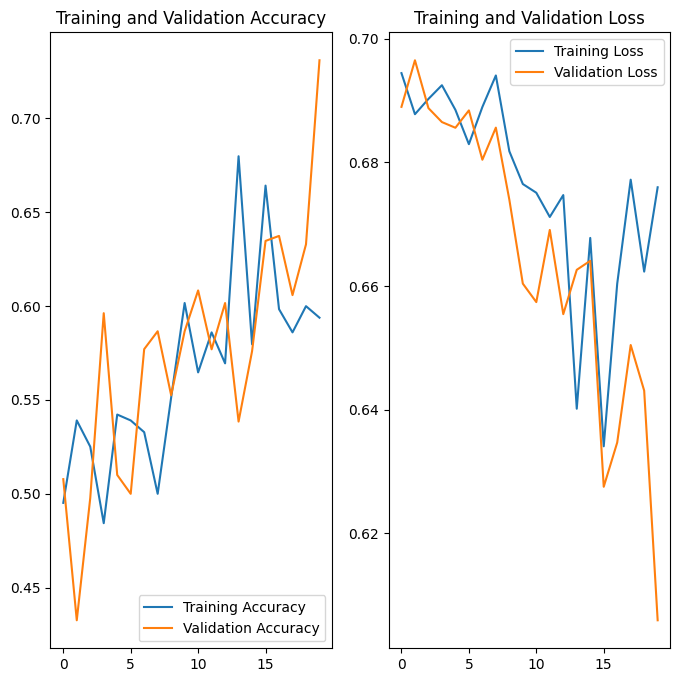

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
